In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import os
path='E:\【ML_DL】\【服装项目】\dataset\shopN\data\shop_'

Using TensorFlow backend.


销售数据取自data_full.7z中的'sale_XXX.csv'系列csv文件，将所有sale数据进行合并。一共有638家店铺，其中取出：拥有数据数目大于100条可以用于lstm时序预测、以及日期可以满足预测条件的店铺，用shop_newest_len100表示       

In [2]:
shop_newest_len100 = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 24, 25, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 54, 56, 57, 58, 59, 61, 62, 63, 64, 65, 69, 70, 72, 75, 76, 77, 78, 81, 83, 85, 86, 88, 89, 90, 91, 93, 94, 95, 100, 101, 105, 106, 107, 110, 111, 114, 115, 121, 122, 125, 127, 128, 132, 133, 134, 135, 146, 147, 151, 156, 157, 158, 159, 160, 162, 163, 164, 167, 169, 170, 172, 178, 179, 183, 185, 186, 189, 196, 199, 200, 201, 205, 206, 209, 218, 221, 223, 225, 233, 234, 237, 239, 246, 250, 260, 272, 299, 308, 311, 321, 451, 481]

保存每个店铺的数据长度

In [3]:
shop_length = []# 保存每个店铺的数据长度
for id in shop_newest_len100:
    df = pd.read_csv(path+str(id)+'.csv',low_memory=False)
    shop_length.append(len(df))

In [4]:
shop_length[:10]

[225, 558, 558, 446, 366, 331, 513, 177, 362, 497]

In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 定义相对误差的计算
def mean_squared_error01(a,b):
    e=[]
    for i in range(len(a)):
        dif = a[i]-b[i]
        e1 = abs(dif / b[i])
        e.append(e1)
    return e

id就是对应的店铺名

In [4]:
id = 7# 这里随机选取第7个店铺进行展示
df = pd.read_csv(path+str(id)+'.csv',low_memory=False)
df=df.drop(['sale_date'],axis=1)
len(df)

513

测试集

In [5]:
len(df[469:])

44

In [6]:
df[469:469+5]

,sale_price,Quantity
469,32759.0,41.0
470,62791.0,65.0
471,51316.0,69.0
472,63851.0,62.0
473,65851.0,73.0


将2018年之前的数据作为训练集，2018年所有数据作为测试集

In [21]:
# 区间缩放
values = df.values
values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

valuess = reframed.values

# 2018年所有数据是倒数44条的数据
num_2018 = 44

train = valuess[:(len(df)-num_2018-1), :]#513-45=468
test = valuess[(len(df)-num_2018-1):, :]

train_X, train_y = train[:, :-2], train[:, -2]
test_X, test_y = test[:, :-2], test[:, -2]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

测试集         
[销售额, 销售数量]

In [13]:
values[469:469+5]

array([[3.2759e+04, 4.1000e+01],
       [6.2791e+04, 6.5000e+01],
       [5.1316e+04, 6.9000e+01],
       [6.3851e+04, 6.2000e+01],
       [6.5851e+04, 7.3000e+01]], dtype=float32)

In [14]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=80, batch_size=8, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 468 samples, validate on 44 samples
Epoch 1/80
 - 6s - loss: 0.1564 - val_loss: 0.1065
Epoch 2/80
 - 1s - loss: 0.1286 - val_loss: 0.1174
Epoch 3/80
 - 1s - loss: 0.1221 - val_loss: 0.1074
Epoch 4/80
 - 1s - loss: 0.1122 - val_loss: 0.0948
Epoch 5/80
 - 1s - loss: 0.1046 - val_loss: 0.0836
Epoch 6/80
 - 1s - loss: 0.0972 - val_loss: 0.0765
Epoch 7/80
 - 1s - loss: 0.0930 - val_loss: 0.0714
Epoch 8/80
 - 1s - loss: 0.0881 - val_loss: 0.0693
Epoch 9/80
 - 1s - loss: 0.0832 - val_loss: 0.0672
Epoch 10/80
 - 1s - loss: 0.0807 - val_loss: 0.0675
Epoch 11/80
 - 1s - loss: 0.0794 - val_loss: 0.0677
Epoch 12/80
 - 1s - loss: 0.0782 - val_loss: 0.0676
Epoch 13/80
 - 1s - loss: 0.0771 - val_loss: 0.0661
Epoch 14/80
 - 1s - loss: 0.0749 - val_loss: 0.0653
Epoch 15/80
 - 1s - loss: 0.0749 - val_loss: 0.0658
Epoch 16/80
 - 1s - loss: 0.0729 - val_loss: 0.0649
Epoch 17/80
 - 1s - loss: 0.0728 - val_loss: 0.0646
Epoch 18/80
 - 1s - loss: 0.0709 - val_loss: 0.0628
Epoch 19/80
 - 1s - loss: 0.

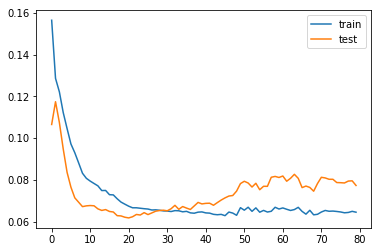

In [15]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
yhat = model.predict(test_X)

yhat.reshape((len(yhat), ))

rmse = mean_squared_error01(test_y,yhat)
error = sum(rmse)/len(test_y)

print(error)

[0.3231634]


##### 因为之前做了归一化，现在要将0-1的数据还原到原来的范围

测试集          
[销售额、销售数量]

In [17]:
values[469:469+5]

array([[3.2759e+04, 4.1000e+01],
       [6.2791e+04, 6.5000e+01],
       [5.1316e+04, 6.9000e+01],
       [6.3851e+04, 6.2000e+01],
       [6.5851e+04, 7.3000e+01]], dtype=float32)

In [22]:
# invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
test_yy=test_y.reshape((len(test_y),1 ))

inv_y = concatenate((test_yy, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [23]:
inv_y[:5]

array([[3.2759e+04, 7.9000e+01],
       [6.2791e+04, 4.1000e+01],
       [5.1316e+04, 6.5000e+01],
       [6.3851e+04, 6.9000e+01],
       [6.5851e+04, 6.2000e+01]], dtype=float32)

In [24]:
inv_ypred = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_ypred = scaler.inverse_transform(inv_ypred)

In [25]:
inv_ypred[:5]

array([[8.0414531e+04, 7.9000000e+01],
       [4.6180379e+04, 4.1000000e+01],
       [7.6587875e+04, 6.5000000e+01],
       [6.4557715e+04, 6.9000000e+01],
       [7.7858422e+04, 6.2000000e+01]], dtype=float32)

In [26]:
len(inv_y)

44

预测2018年销售额的相对误差

In [30]:
sum(inv_y)

array([1850086.,    3174.], dtype=float32)

In [31]:
len(inv_ypred)

44

In [32]:
sum(inv_ypred)

array([2445541.,    3174.], dtype=float32)

In [33]:
abs(2445541-1850086)/1850086

0.32185260577075875